In [1]:
import scipy.io
import os
import numpy as np

In [2]:
# Define the main path and file paths
main_path = r'D:\Fateme A\23_Brain Electrophysiological Recording during Olfactory Stimulation in Mild Cognitive Impairment and Alzheimer Disease Patients An EEG Dataset'

In [3]:
import random

# Define file names
file_paths = {
    "AD": os.path.join(main_path, "AD.mat"),
    "normal": os.path.join(main_path, "normal.mat"),
    "MCI": os.path.join(main_path, "MCI.mat")
}

# Prepare storage per class
class_data = {
    "AD": [],
    "normal": [],
    "MCI": []
}

# Load and organize all trials by class
for label, file_path in file_paths.items():
    mat_data = scipy.io.loadmat(file_path)
    eeg_data = mat_data[label]  # Assuming variable name matches label

    for patient_id in range(eeg_data.shape[1]):  # shape: (1, N_patients)
        patient_data = eeg_data[0][patient_id]
        trials = patient_data[0]  # shape: channels x samples x trials

        # Split into individual trials and add to class list
        for i in range(trials.shape[2]):
            class_data[label].append(trials[:, :, i])  # One trial

# Calculate total trial counts per class
trial_counts = {label: len(trials) for label, trials in class_data.items()}
print("Trial counts per class:", trial_counts)

# Find the minimum number of trials across the 3 classes
min_trial_count = min(trial_counts.values())
print("trial number to balance classes:", min_trial_count)

# Randomly select min_trial_count trials from each class
balanced_data = []
balanced_labels = []

for label in class_data:
    selected_trials = random.sample(class_data[label], min_trial_count)
    balanced_data.extend(selected_trials)
    balanced_labels.extend([label] * min_trial_count)

# Convert to arrays
data_array = np.stack(balanced_data)  # shape: total_trials x channels x samples
labels_array = np.array(balanced_labels)

# Final output info
print("3 * 848 = ", data_array.shape[0])
print('we used random selection of trials to balance classes')

print("Final balanced dataset:")
print("Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)
print("Labels:", np.unique(labels_array, return_counts=True))


Trial counts per class: {'AD': 1352, 'normal': 1677, 'MCI': 848}
trial number to balance classes: 848
3 * 848 =  2544
we used random selection of trials to balance classes
Final balanced dataset:
Data shape: (2544, 4, 600)
Labels shape: (2544,)
Labels: (array(['AD', 'MCI', 'normal'], dtype='<U6'), array([848, 848, 848]))


## Phase, Transfer Entropy, and Entropy Functions

In [11]:
from scipy.signal import hilbert
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from scipy.signal import butter, filtfilt
from collections import Counter

# Bandpass filter
def bandpass_filter(signal, lowcut=0.1, highcut=40.0, fs=200.0, order=3):
    """Apply a Butterworth bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def compute_shannon_entropy(signal, bins=100):
    """Compute Shannon entropy of a signal (time domain) using histogram binning."""
    histogram, bin_edges = np.histogram(signal, bins=bins, density=True)
    probs = histogram / np.sum(histogram)  # Normalize to get probability distribution
    probs = probs[probs > 0]  # Remove zero entries to avoid log(0)
    return entropy(probs)

def extract_shannon_entropy_features(multichannel_signal):
    """
    Extract Shannon entropy features from all EEG channels in a trial.
    """
    features = []
    for channel_signal in multichannel_signal:
        filtered_signal = bandpass_filter(channel_signal, fs=200)
        entropy_val = compute_shannon_entropy(filtered_signal)
        features.append(entropy_val)
    return features  # List of 4 entropy values, one per channel

def transfer_entropy(source, target, delay=1, bins=10):
    """
    Calculate transfer entropy from source to target time series.
    
    Parameters:
    source: array-like, source time series
    target: array-like, target time series
    delay: int, time delay (default=1)
    bins: int, number of bins for discretization (default=10)
    
    Returns:
    float: transfer entropy value
    """
    # Ensure inputs are numpy arrays
    source = np.array(source)
    target = np.array(target)
    
    # Create discretized versions of the signals
    source_binned = np.digitize(source, np.linspace(min(source), max(source), bins))
    target_binned = np.digitize(target, np.linspace(min(target), max(target), bins))
    
    # Create time-shifted versions
    target_past = target_binned[:-delay]
    target_future = target_binned[delay:]
    source_past = source_binned[:-delay]
    
    # Calculate joint and marginal probabilities
    states = list(zip(target_future, target_past, source_past))
    p_joint = Counter(states)
    total_states = len(states)
    
    # Normalize to get probabilities
    for k in p_joint:
        p_joint[k] = p_joint[k] / total_states
    
    # Calculate conditional states
    states_condition = list(zip(target_past, source_past))
    p_condition = Counter(states_condition)
    for k in p_condition:
        p_condition[k] = p_condition[k] / total_states
    
    states_target = list(zip(target_future, target_past))
    p_target = Counter(states_target)
    for k in p_target:
        p_target[k] = p_target[k] / total_states
    
    # Calculate transfer entropy
    te = 0
    for state in p_joint:
        future, past, source_p = state
        if p_joint[state] > 0:
            dividend = p_joint[state] * p_condition[(past, source_p)]
            divisor = p_target[(future, past)] * p_condition[(past, source_p)]
            if divisor > 0:  # Add check to prevent division by zero
                te += p_joint[state] * np.log2(dividend / divisor)
    
    return te

import numpy as np
from scipy.signal import hilbert
from sklearn.preprocessing import KBinsDiscretizer

def compute_phase(signal):
    """Compute instantaneous phase via Hilbert transform."""
    analytic_signal = hilbert(signal)
    phase = np.angle(analytic_signal)
    return phase

def bin_phases(phases, n_bins):
    """Discretize continuous phases into n_bins states uniformly."""
    # phases in [-π, π]
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform', subsample=None)
    return est.fit_transform(phases.reshape(-1, 1)).astype(int).flatten()

def estimate_joint_probabilities(data, n_bins):
    """Estimate joint probability distribution from 2D array of binned variables."""
    # Each row = variable, columns = samples
    # data.shape = (variables, N)
    variables, N = data.shape
    joint_counts = np.zeros([n_bins]*variables, dtype=np.float64)
    for i in range(N):
        idx = tuple(data[:, i])
        joint_counts[idx] += 1
    joint_probs = joint_counts / joint_counts.sum()
    return joint_probs

def phase_transfer_entropy(signal_a, signal_b, delta=1, n_bins=8):
    """
    Computes Phase Transfer Entropy from signal_b (driver) to signal_a (target)
    using the formula from the image.
    """
    # Step 1: Compute instantaneous phases
    phase_a = compute_phase(signal_a)
    phase_b = compute_phase(signal_b)

    # Step 2: Embed
    # A_delta = future of A
    A_delta = phase_a[delta:]
    A_past = phase_a[:-delta]
    B_past = phase_b[:-delta]

    N_effective = len(A_delta)

    # Step 3: Bin phases
    A_delta_binned = bin_phases(A_delta, n_bins)
    A_past_binned = bin_phases(A_past, n_bins)
    B_past_binned = bin_phases(B_past, n_bins)

    # Step 4: Build joint data
    data_A_delta_A_B = np.vstack([A_delta_binned, A_past_binned, B_past_binned])
    data_A_delta_A = np.vstack([A_delta_binned, A_past_binned])

    # Step 5: Estimate probabilities
    p_A_delta_A_B = estimate_joint_probabilities(data_A_delta_A_B, n_bins)
    p_A_delta_A = estimate_joint_probabilities(data_A_delta_A, n_bins)

    # Step 6: Compute sum
    PTE = 0.0
    for i in range(n_bins):
        for j in range(n_bins):
            for k in range(n_bins):
                p_joint = p_A_delta_A_B[i, j, k]
                if p_joint == 0:
                    continue

                p_cond_AB = p_joint / (p_A_delta_A_B[:, j, k].sum() + 1e-12)
                p_cond_A = p_A_delta_A[i, j] / (p_A_delta_A[:, j].sum() + 1e-12)

                if p_cond_AB > 0 and p_cond_A > 0:
                    PTE += p_joint * np.log2(p_cond_AB / p_cond_A)

    return PTE


## Feature extraction 

In [ ]:
from tqdm import tqdm

# EEG frequency bands
FREQ_BANDS = {
    "delta": (0.1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (30, 40)
}

def process_data(data_array):
    """
    Process EEG data, computing transfer entropy between frequency bands
    for each channel (instead of between channels).
    
    Parameters:
    data_array: numpy array of shape (n_trials, n_channels, n_samples)
    
    Returns:
    X: numpy array of shape (n_trials, n_features)
    feature_names: list of feature names for channel-band pairs
    """
    n_trials, n_channels, n_samples = data_array.shape
    band_names = list(FREQ_BANDS.keys())
    
    # All unique band pairs (e.g., delta→theta, delta→alpha, etc.)
    band_pairs = [(b1, b2) for i, b1 in enumerate(band_names) 
                           for j, b2 in enumerate(band_names) if i != j]
    
    # Channel names (adjust according to your actual channels)
    channel_names = ['Fp1', 'Fz', 'Cz', 'Pz'][:n_channels]
    
    features = []
    feature_names = []
    
    # Generate feature names first
    for ch_name in channel_names:
        # Shannon entropy for each band
        for band_name in band_names:
            feature_names.append(f'Shannon_{ch_name}_{band_name}')  # 4 ch x 5 bands = 20 features
        
        # Phase TE between band pairs
        for b1, b2 in band_pairs:
            feature_names.append(f'PhaseTE_{ch_name}_{b1}_to_{b2}') # 4 ch x 20 band_pairs = 20 features
        
        # Regular TE between band pairs
        for b1, b2 in band_pairs:
            feature_names.append(f'TE_{ch_name}_{b1}_to_{b2}') # 4 ch x 20 band_pairs = 20 features

    print(f"Processing {n_trials} trials with {len(feature_names)} features per trial...")

    for trial in tqdm(range(n_trials), desc="Extracting features"):
        signal = np.array(data_array[trial, :, :], dtype=np.float64)
        
        trial_features = []
        
        for ch_idx in range(n_channels):
            ch_signal = signal[ch_idx]
            
            # Filter signal into different frequency bands
            band_signals = {}
            for band_name, (low, high) in FREQ_BANDS.items():
                band_signals[band_name] = bandpass_filter(ch_signal, low, high, fs=200)  
            
            # Shannon entropy features for each band
            shannon_features = []
            for band_name in band_names:
                shannon_val = extract_shannon_entropy_features(band_signals[band_name])  # 4 ch x 5 bands = 20 features
                shannon_features.append(shannon_val)
            
            # Phase transfer entropy between band pairs
            phase_te_features = []
            for b1, b2 in band_pairs:
                phase_te_val = phase_transfer_entropy(band_signals[b1], band_signals[b2])  # 4 ch x 20 band_pairs = 80 features
                phase_te_features.append(phase_te_val)
            
            # Regular transfer entropy between band pairs
            te_features = []
            for b1, b2 in band_pairs:
                te_val = transfer_entropy(band_signals[b1], band_signals[b2])  # 4 ch x 20 band_pairs = 80 features
                te_features.append(te_val)
            
            # Concatenate all features for this channel
            channel_features = shannon_features + phase_te_features + te_features
            trial_features.extend(channel_features)
        
        features.append(trial_features)
    
    X = np.array(features)
    
    print(f"Feature extraction completed. Shape: {X.shape}")
    print(f"Total features: {len(feature_names)}")   # Total features should be 180
    
    return X, feature_names

## Comparing Classifiers

In [14]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel

# Define classifiers
classifiers = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        tol=1e-4,
        C=1.0
    ),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

def evaluate_features(X, y_encoded, feature_names):
    """
    Evaluate features using 10-fold cross-validation with multiple classifiers.
    
    Parameters:
    X: Feature matrix
    y_encoded: Encoded labels
    feature_names: List of feature names
    
    Returns:
    results: Dictionary with classifier performance results
    """
    print("\n=== Evaluating Features with 10-Fold Cross-Validation ===")
    print(f"Dataset shape: {X.shape}")
    print(f"Number of features: {len(feature_names)}")

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results = {}
    print("\n=== Classifier Performance (10-fold Accuracy) ===")

    for name, clf in classifiers.items():
        print(f"\n--- Running {name} ---")

        fold_scores = []

        for i, (train_idx, test_idx) in tqdm(enumerate(skf.split(X, y_encoded), 1), 
                                           total=10, desc=f'{name} Folds'):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', clf)
            ])
            pipeline.fit(X[train_idx], y_encoded[train_idx])
            score = pipeline.score(X[test_idx], y_encoded[test_idx])
            fold_scores.append(score)
        
        scores = np.array(fold_scores)

        results[name] = {
            'Mean Accuracy': np.mean(scores),
            'Std Accuracy': np.std(scores),
            'All Scores': scores
        }

        print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Plot mean accuracies
    accuracy_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Mean Accuracy': [results[m]['Mean Accuracy'] for m in results],
        'Std Accuracy': [results[m]['Std Accuracy'] for m in results]
    }).sort_values(by='Mean Accuracy', ascending=False)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Model',
        y='Mean Accuracy',
        data=accuracy_df,
        hue='Model',
        palette='mako',
        legend=False
    )

    for p, (_, row) in zip(ax.patches, accuracy_df.iterrows()):
        ax.annotate(f'{row["Mean Accuracy"]:.3f}±{row["Std Accuracy"]:.3f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

    plt.title("10-Fold Cross-Validated Accuracy using EEG Frequency Band Transfer Entropy Features")
    plt.ylabel("Accuracy")
    plt.xlabel("Classifier")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results


## Feature Importance

In [15]:
from sklearn.feature_selection import SelectFromModel

def feature_importance_and_selection(X, y, feature_names=None, plot_top_n=28):
    """
    Evaluate and select important features using RandomForest.
    
    Parameters:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Label vector.
        feature_names (list): Optional, names of features for plotting.
        plot_top_n (int): Number of top features to display.

    Returns:
        X_selected (np.ndarray): Subset of X with selected features.
        selected_indices (np.ndarray): Indices of selected features.
        selected_feature_names (list): Names of selected features.
    """
    print("\n=== Feature Importance & Selection using Random Forest ===")

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get importance scores
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot top N important features
    top_n = min(plot_top_n, len(importances))
    
    plt.figure(figsize=(12, 8))
    top_features = [feature_names[i] if feature_names else f'Feature_{i}' for i in indices[:top_n]]
    top_importances = importances[indices[:top_n]]
    
    sns.barplot(y=top_features, x=top_importances, palette='viridis')
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Select important features (threshold = mean)
    selector = SelectFromModel(rf, threshold='mean', prefit=True)
    X_selected = selector.transform(X)
    selected_indices = selector.get_support(indices=True)
    
    selected_feature_names = [feature_names[i] for i in selected_indices] if feature_names else None
    
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
    
    if selected_feature_names:
        print("\nSelected features:")
        for i, name in enumerate(selected_feature_names):
            print(f"{i+1:2d}. {name}")

    return X_selected, selected_indices, selected_feature_names

def analyze_feature_types(feature_names, selected_indices):
    """
    Analyze the types of selected features (Shannon, PhaseTE, TE).
    
    Parameters:
    feature_names: List of all feature names
    selected_indices: Indices of selected features
    """
    print("\n=== Feature Type Analysis ===")
    
    selected_features = [feature_names[i] for i in selected_indices]
    
    # Count feature types
    feature_types = {'Shannon': 0, 'PhaseTE': 0, 'TE': 0}
    band_counts = {band: 0 for band in FREQ_BANDS.keys()}
    channel_counts = {}
    
    for feature in selected_features:
        if 'Shannon' in feature:
            feature_types['Shannon'] += 1
            # Extract band name
            parts = feature.split('_')
            if len(parts) >= 3:
                band = parts[-1]
                if band in band_counts:
                    band_counts[band] += 1
        elif 'PhaseTE' in feature:
            feature_types['PhaseTE'] += 1
        elif 'TE' in feature:
            feature_types['TE'] += 1
        
        # Count channels
        parts = feature.split('_')
        if len(parts) >= 2:
            channel = parts[1]
            channel_counts[channel] = channel_counts.get(channel, 0) + 1
    
    # Plot feature type distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Feature types
    axes[0].pie(feature_types.values(), labels=feature_types.keys(), autopct='%1.1f%%')
    axes[0].set_title('Selected Feature Types')
    
    # Channel distribution
    if channel_counts:
        axes[1].bar(channel_counts.keys(), channel_counts.values())
        axes[1].set_title('Features by Channel')
        axes[1].set_ylabel('Count')
    
    # Band distribution (for Shannon entropy features)
    non_zero_bands = {k: v for k, v in band_counts.items() if v > 0}
    if non_zero_bands:
        axes[2].bar(non_zero_bands.keys(), non_zero_bands.values())
        axes[2].set_title('Shannon Entropy Features by Band')
        axes[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Run previous functions 

In [16]:
from sklearn.model_selection import train_test_split

# Main analysis pipeline
def run_complete_analysis(data_array, labels_array):
    """
    Run the complete analysis pipeline.
    
    Parameters:
    data_array: EEG data array of shape (n_trials, n_channels, n_samples)
    labels_array: Labels for each trial
    
    Returns:
    Dictionary containing all results
    """
    print("=== Starting Complete EEG Frequency Band Analysis ===")
    
    # Step 1: Extract features
    print("\nStep 1: Feature Extraction")
    X, feature_names = process_data(data_array)
    
    # Step 2: Encode labels
    print("\nStep 2: Label Encoding")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_array)
    
    print(f"Classes: {label_encoder.classes_}")
    print(f"Class distribution: {Counter(y_encoded)}")
    
    # Step 3: Evaluate all features
    print("\nStep 3: Feature Evaluation")
    results = evaluate_features(X, y_encoded, feature_names)
    
    # Step 4: Feature importance and selection
    print("\nStep 4: Feature Importance Analysis")
    X_selected, selected_indices, selected_feature_names = feature_importance_and_selection(
        X, y_encoded, feature_names, plot_top_n=min(30, len(feature_names))
    )
    
    # Step 5: Analyze feature types
    analyze_feature_types(feature_names, selected_indices)
    
    # Step 6: Evaluate with selected features
    print("\nStep 5: Evaluation with Selected Features")
    selected_results = evaluate_features(X_selected, y_encoded, selected_feature_names)
    
    return {
        'X_all': X,
        'X_selected': X_selected,
        'feature_names': feature_names,
        'selected_feature_names': selected_feature_names,
        'selected_indices': selected_indices,
        'results_all': results,
        'results_selected': selected_results,
        'y_encoded': y_encoded,
        'label_encoder': label_encoder
    }

# Example usage (uncomment when you have your data):

# # Assuming you have your data loaded as:
# # data_array: shape (n_trials, n_channels, n_samples)
# # labels_array: shape (n_trials,)

# analysis_results = run_complete_analysis(data_array, labels_array)

# # Access results:
# print("Best classifier with all features:", 
#       max(analysis_results['results_all'].items(), key=lambda x: x[1]['Mean Accuracy']))
# print("Best classifier with selected features:", 
#       max(analysis_results['results_selected'].items(), key=lambda x: x[1]['Mean Accuracy']))

=== Starting Complete EEG Frequency Band Analysis ===

Step 1: Feature Extraction
Processing 2544 trials with 100 features per trial...


Extracting features: 100%|██████████| 2544/2544 [12:22<00:00,  3.43it/s]


Feature extraction completed. Shape: (2544, 100)
Total features: 100

Step 2: Label Encoding
Classes: ['AD' 'MCI' 'normal']
Class distribution: Counter({np.int64(0): 848, np.int64(2): 848, np.int64(1): 848})

Step 3: Feature Evaluation

=== Evaluating Features with 10-Fold Cross-Validation ===
Dataset shape: (2544, 100)
Number of features: 100

=== Classifier Performance (10-fold Accuracy) ===

--- Running SVM ---


SVM Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


SVM: 0.628 ± 0.023

--- Running Random Forest ---


Random Forest Folds: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Random Forest: 0.609 ± 0.028

--- Running Naive Bayes ---


Naive Bayes Folds: 100%|██████████| 10/10 [00:00<00:00, 106.67it/s]


Naive Bayes: 0.502 ± 0.028

--- Running Logistic Regression ---


Logistic Regression Folds: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


Logistic Regression: 0.571 ± 0.020

--- Running Decision Tree ---


Decision Tree Folds: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Decision Tree: 0.478 ± 0.031


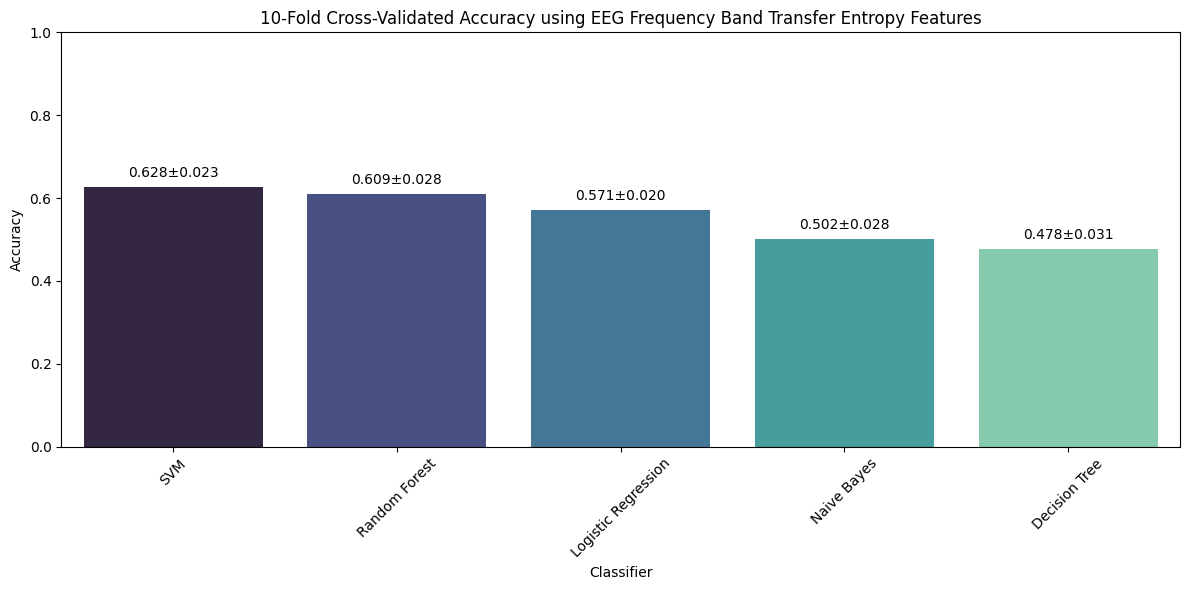


Step 4: Feature Importance Analysis

=== Feature Importance & Selection using Random Forest ===


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10552\2770067375.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_features, x=top_importances, palette='viridis')


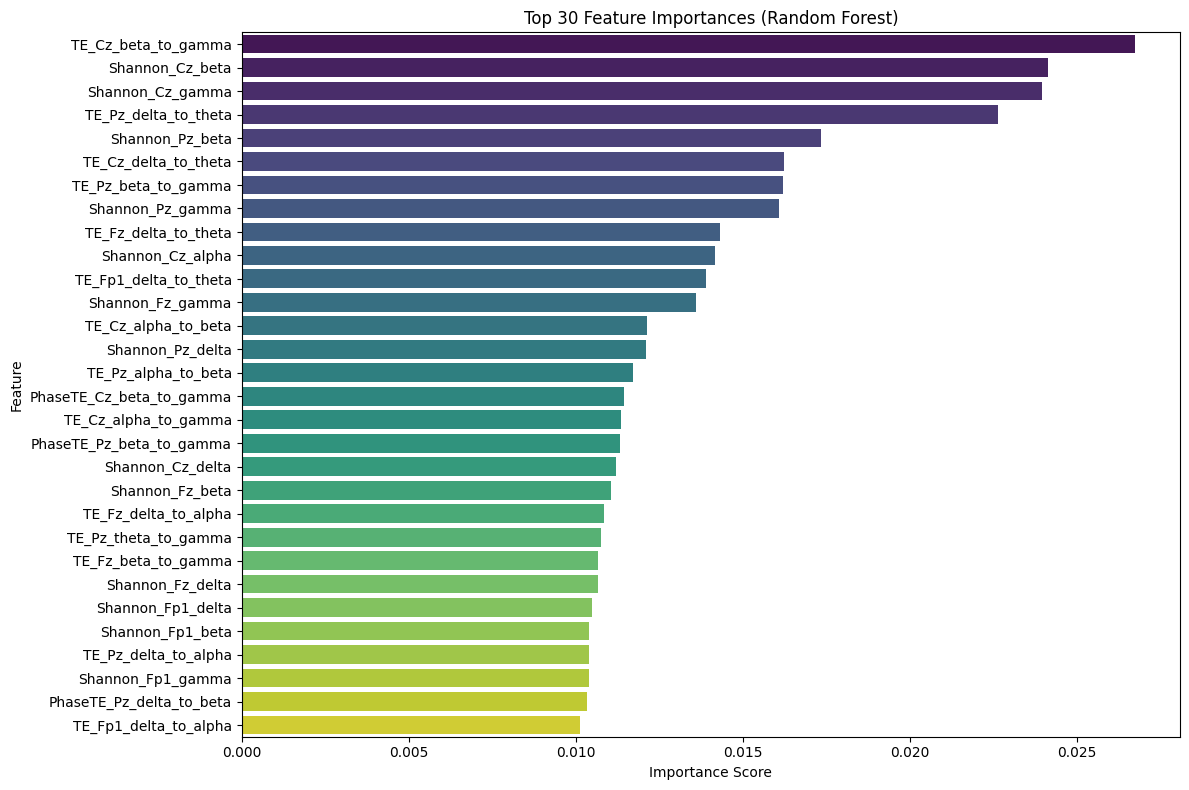

Selected 31 features out of 100

Selected features:
 1. Shannon_Fp1_delta
 2. Shannon_Fp1_beta
 3. Shannon_Fp1_gamma
 4. TE_Fp1_delta_to_theta
 5. TE_Fp1_delta_to_alpha
 6. Shannon_Fz_delta
 7. Shannon_Fz_beta
 8. Shannon_Fz_gamma
 9. TE_Fz_delta_to_theta
10. TE_Fz_delta_to_alpha
11. TE_Fz_beta_to_gamma
12. Shannon_Cz_delta
13. Shannon_Cz_alpha
14. Shannon_Cz_beta
15. Shannon_Cz_gamma
16. PhaseTE_Cz_beta_to_gamma
17. TE_Cz_delta_to_theta
18. TE_Cz_alpha_to_beta
19. TE_Cz_alpha_to_gamma
20. TE_Cz_beta_to_gamma
21. Shannon_Pz_delta
22. Shannon_Pz_alpha
23. Shannon_Pz_beta
24. Shannon_Pz_gamma
25. PhaseTE_Pz_delta_to_beta
26. PhaseTE_Pz_beta_to_gamma
27. TE_Pz_delta_to_theta
28. TE_Pz_delta_to_alpha
29. TE_Pz_theta_to_gamma
30. TE_Pz_alpha_to_beta
31. TE_Pz_beta_to_gamma

=== Feature Type Analysis ===


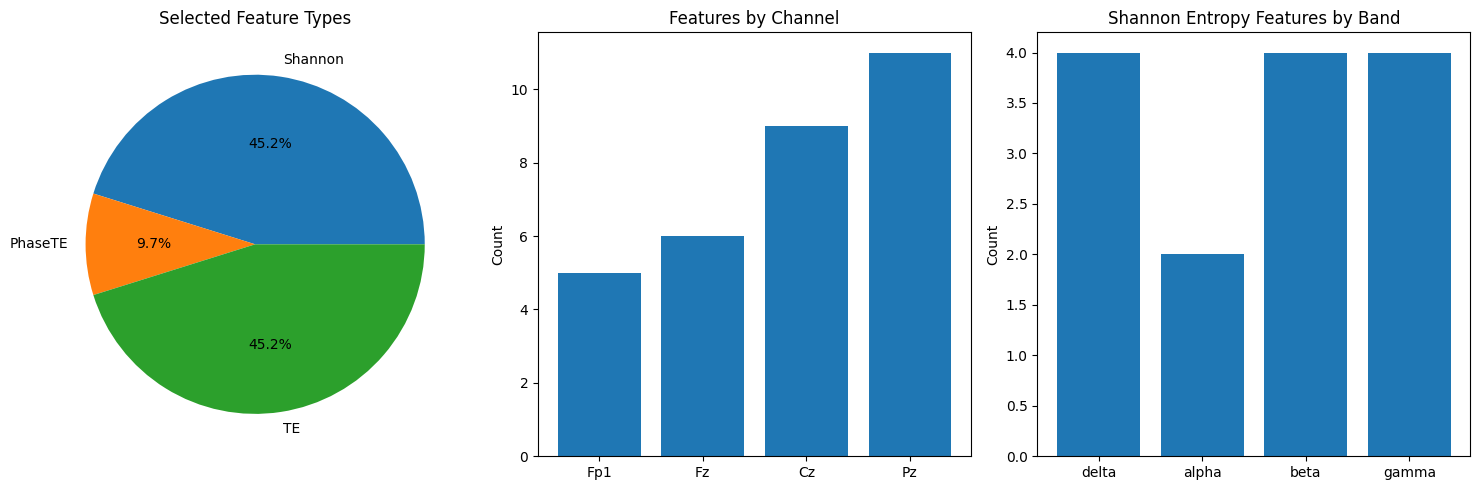


Step 5: Evaluation with Selected Features

=== Evaluating Features with 10-Fold Cross-Validation ===
Dataset shape: (2544, 31)
Number of features: 31

=== Classifier Performance (10-fold Accuracy) ===

--- Running SVM ---


SVM Folds: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


SVM: 0.613 ± 0.025

--- Running Random Forest ---


Random Forest Folds: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


Random Forest: 0.621 ± 0.031

--- Running Naive Bayes ---


Naive Bayes Folds: 100%|██████████| 10/10 [00:00<00:00, 167.01it/s]


Naive Bayes: 0.510 ± 0.027

--- Running Logistic Regression ---


Logistic Regression Folds: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


Logistic Regression: 0.567 ± 0.026

--- Running Decision Tree ---


Decision Tree Folds: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


Decision Tree: 0.502 ± 0.027


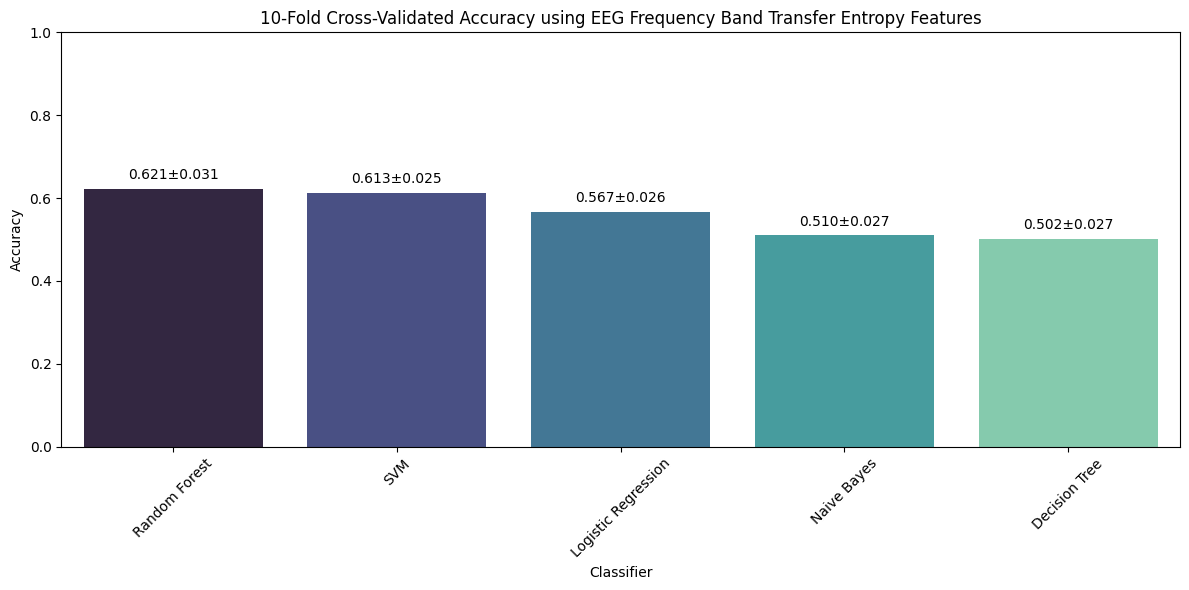

Best classifier with all features: ('SVM', {'Mean Accuracy': np.float64(0.627736606453605), 'Std Accuracy': np.float64(0.023272166130496433), 'All Scores': array([0.62352941, 0.62352941, 0.68235294, 0.61960784, 0.62992126,
       0.64173228, 0.64566929, 0.6023622 , 0.5984252 , 0.61023622])})
Best classifier with selected features: ('Random Forest', {'Mean Accuracy': np.float64(0.6214559209510575), 'Std Accuracy': np.float64(0.03119724704889758), 'All Scores': array([0.62352941, 0.65098039, 0.6627451 , 0.56470588, 0.65354331,
       0.5984252 , 0.57874016, 0.61023622, 0.63779528, 0.63385827])})


In [17]:
analysis_results = run_complete_analysis(data_array, labels_array)

# Access results:
print("Best classifier with all features:", 
      max(analysis_results['results_all'].items(), key=lambda x: x[1]['Mean Accuracy']))
print("Best classifier with selected features:", 
      max(analysis_results['results_selected'].items(), key=lambda x: x[1]['Mean Accuracy']))

# Test SVM and RF with selected features


=== Final Model Evaluation: RF and SVM on Selected Features ===
Train set shape: (2035, 31)
Test set shape: (509, 31)
Train class distribution: Counter({np.int64(0): 679, np.int64(2): 678, np.int64(1): 678})
Test class distribution: Counter({np.int64(1): 170, np.int64(2): 170, np.int64(0): 169})

Evaluating Random Forest
Random Forest Accuracy: 0.611

Classification Report:
              precision    recall  f1-score   support

          AD       0.60      0.53      0.56       169
         MCI       0.62      0.85      0.72       170
      normal       0.60      0.45      0.51       170

    accuracy                           0.61       509
   macro avg       0.61      0.61      0.60       509
weighted avg       0.61      0.61      0.60       509



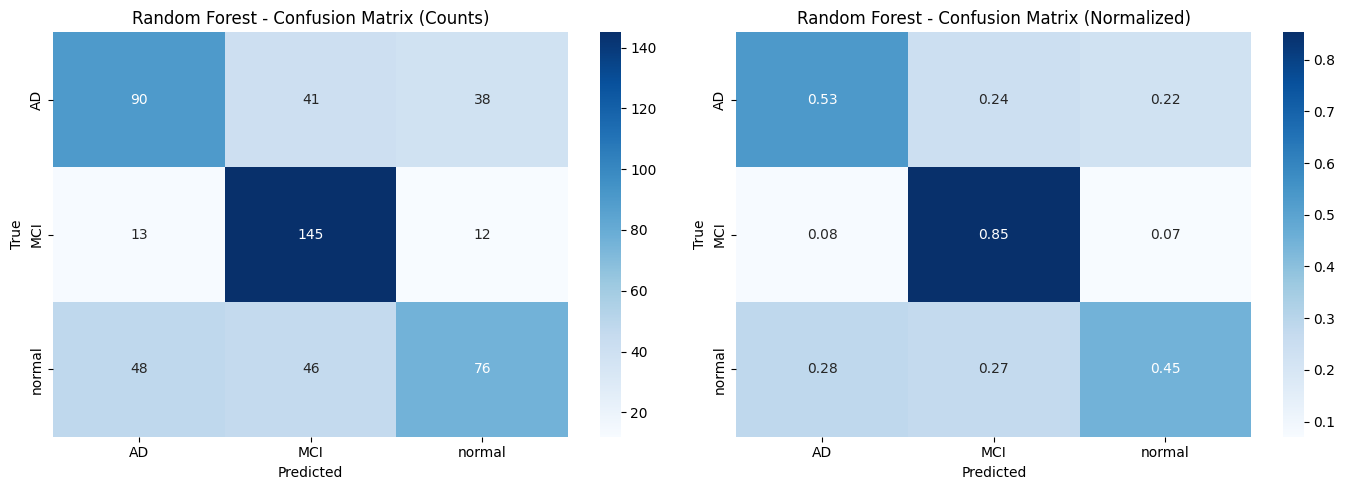

Precision (weighted): 0.608
Recall (weighted):    0.611
F1-Score (weighted):  0.599

Evaluating SVM (RBF)
SVM (RBF) Accuracy: 0.617

Classification Report:
              precision    recall  f1-score   support

          AD       0.70      0.48      0.57       169
         MCI       0.59      0.88      0.71       170
      normal       0.60      0.49      0.54       170

    accuracy                           0.62       509
   macro avg       0.63      0.62      0.60       509
weighted avg       0.63      0.62      0.60       509



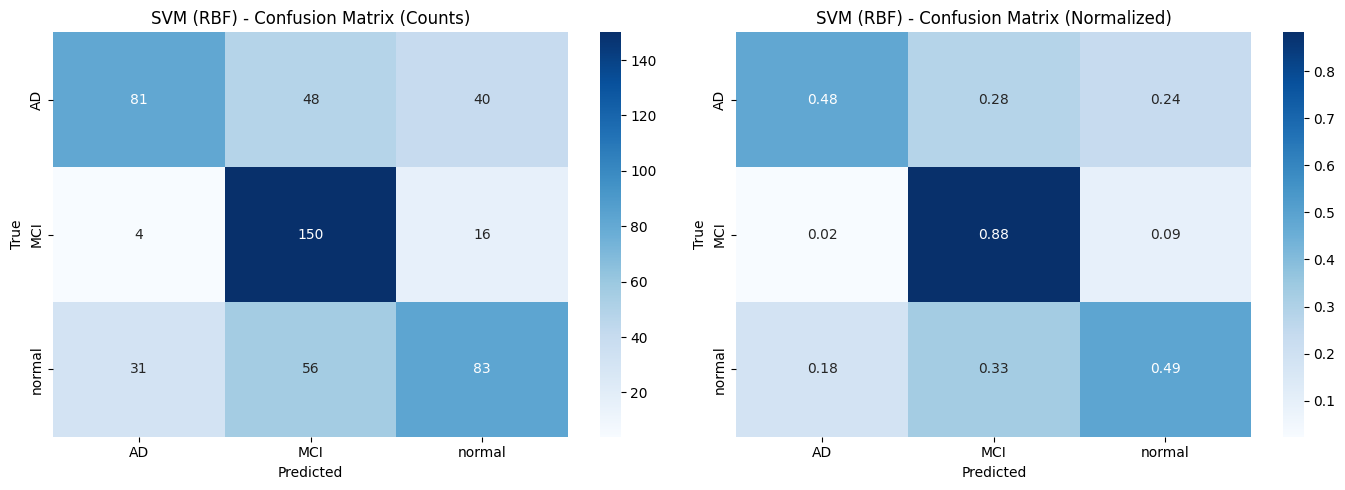

Precision (weighted): 0.629
Recall (weighted):    0.617
F1-Score (weighted):  0.604

=== Model Comparison: All Features vs Selected Features ===

Random Forest:
  All Features (100):      0.593
  Selected Features (31): 0.611
  Improvement:        +0.018

SVM (RBF):
  All Features (100):      0.605
  Selected Features (31): 0.617
  Improvement:        +0.012


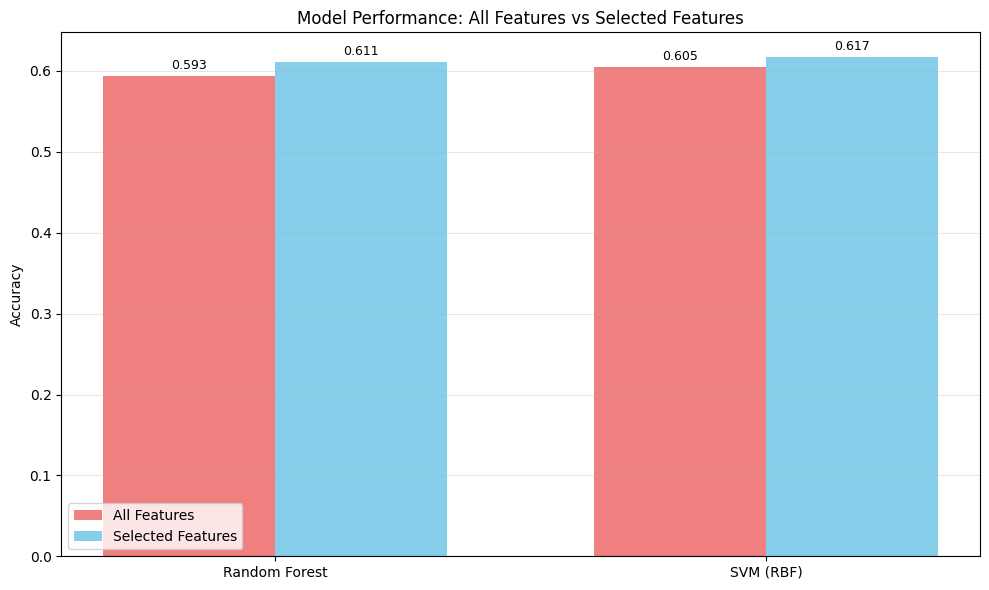

In [18]:
# Extract data from analysis results
X_selected = analysis_results['X_selected']
X_all = analysis_results['X_all']
y_encoded = analysis_results['y_encoded']
label_encoder = analysis_results['label_encoder']
feature_names = analysis_results['feature_names']
selected_feature_names = analysis_results['selected_feature_names']
selected_indices = analysis_results['selected_indices']

from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


def final_model_evaluation(X_all, y_encoded, selected_indices, label_encoder, test_size=0.2, random_state=42):
    """
    Final evaluation of RF and SVM models with confusion matrices.
    """
    print("\n=== Final Model Evaluation: RF and SVM on Selected Features ===")
    
    # Apply feature selection
    X_selected = X_all[:, selected_indices]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"Train set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Train class distribution: {Counter(y_train)}")
    print(f"Test class distribution: {Counter(y_test)}")
    
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42)
    }
    
    # Evaluate each model
    for model_name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {model_name}")
        print(f"{'='*50}")
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {acc:.3f}")
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        
        # Confusion matrix (normalized + counts)
        conf_mat = confusion_matrix(y_test, y_pred)
        conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax[0])
        ax[0].set_title(f'{model_name} - Confusion Matrix (Counts)')
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')
        
        sns.heatmap(conf_mat_norm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax[1])
        ax[1].set_title(f'{model_name} - Confusion Matrix (Normalized)')
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        
        # Additional metrics
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Precision (weighted): {precision:.3f}")
        print(f"Recall (weighted):    {recall:.3f}")
        print(f"F1-Score (weighted):  {f1:.3f}")


def compare_models_performance(X_all, y_encoded, selected_indices, label_encoder, test_size=0.2, random_state=42):
    """
    Compare performance of all vs selected features for RF and SVM.
    """
    print("\n=== Model Comparison: All Features vs Selected Features ===")
    
    X_selected = X_all[:, selected_indices]
    
    # Train/test split (same y split for fair comparison)
    X_train_all, X_test_all, y_train, y_test = train_test_split(
        X_all, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    X_train_sel, X_test_sel, _, _ = train_test_split(
        X_selected, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
        'SVM (RBF)': SVC(kernel='rbf', random_state=42)
    }
    
    results_comparison = []
    
    for model_name, model in models.items():
        pipeline_all = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
        pipeline_all.fit(X_train_all, y_train)
        acc_all = pipeline_all.score(X_test_all, y_test)
        
        pipeline_sel = Pipeline([('scaler', StandardScaler()), ('classifier', model)])
        pipeline_sel.fit(X_train_sel, y_train)
        acc_sel = pipeline_sel.score(X_test_sel, y_test)
        
        results_comparison.append({
            'Model': model_name,
            'All Features': acc_all,
            'Selected Features': acc_sel,
            'Improvement': acc_sel - acc_all
        })
        
        print(f"\n{model_name}:")
        print(f"  All Features ({X_all.shape[1]}):      {acc_all:.3f}")
        print(f"  Selected Features ({X_selected.shape[1]}): {acc_sel:.3f}")
        print(f"  Improvement:        {acc_sel - acc_all:+.3f}")
    
    df_comparison = pd.DataFrame(results_comparison)
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(df_comparison))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df_comparison['All Features'], width, label='All Features', color='lightcoral')
    bars2 = ax.bar(x + width/2, df_comparison['Selected Features'], width, label='Selected Features', color='skyblue')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance: All Features vs Selected Features')
    ax.set_xticks(x)
    ax.set_xticklabels(df_comparison['Model'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Annotate bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Final evaluation
final_model_evaluation(
    analysis_results['X_all'], 
    y_encoded, 
    analysis_results['selected_indices'], 
    analysis_results['label_encoder']
)

# Compare models
compare_models_performance(
    analysis_results['X_all'], 
    y_encoded, 
    analysis_results['selected_indices'], 
    analysis_results['label_encoder']
)


In [ ]:
# All unique band pairs (e.g., delta→theta, delta→alpha, etc.)
band_pairs = [(b1, b2) for i, b1 in enumerate(band_names) 
                        for j, b2 in enumerate(band_names) if i != j]